<a href="https://colab.research.google.com/github/cleitonmoya/CPS765_Trabalho2/blob/main/CPS765_Trab2_Construcao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Construção e Análise de uma Rede da Covid-19 nos Municípios Brasileiros
*   **Disciplina**: CPS 765 - Redes Complexas
*   **Professor**: Daniel R. Figueiredo
*   **Alunos**: Cleiton Almeida e Girolamo Santoro



In [ ]:
import numpy as np
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

## Parte I: Construção da Rede

### 1 Pré-Processamento

Série temporal da Covid-19 nos municípios:

In [ ]:
url = 'https://raw.githubusercontent.com/cleitonmoya/CPS765_Trabalho2/main/datasets/casos_idhf_v2.csv'
df = pd.read_csv(url, decimal=',', sep=';', index_col=0, dayfirst=True, parse_dates=True)
df.sort_index(inplace=True)
print(df)
for col in df:
  print (col)

           state             city  ...  city_ibge_code      idhf
date                               ...                          
2020-02-25    SP        São Paulo  ...         3550308  0.837017
2020-02-26    SP        São Paulo  ...         3550308  0.837017
2020-02-27    SP        São Paulo  ...         3550308  0.837017
2020-02-28    SP        São Paulo  ...         3550308  0.837017
2020-02-29    SP        São Paulo  ...         3550308  0.837017
...          ...              ...  ...             ...       ...
2020-11-19    RS      Arvorezinha  ...         4301404  0.734564
2020-11-19    SP        Promissão  ...         3541604  0.745000
2020-11-19    SP         Angatuba  ...         3502200  0.763273
2020-11-19    RS  Arroio do Tigre  ...         4301206  0.673605
2020-11-19    SC            Timbó  ...         4218202  0.827758

[998830 rows x 7 columns]
state
city
confirmed
deaths
estimated_population
city_ibge_code
idhf


Municípios:


In [ ]:
url = 'https://raw.githubusercontent.com/cleitonmoya/CPS765_Trabalho2/main/datasets/municipios.csv'
df_mun = pd.read_csv(url, sep=';', index_col=0)
print(df_mun)
for col in df_mun:
  print(col)

               regiao  uf  ... porte_idh  porte_pib
cod                        ...                     
1100015         Norte  RO  ...         2          2
1100023         Norte  RO  ...         3          2
1100031         Norte  RO  ...         2          2
1100049         Norte  RO  ...         3          2
1100056         Norte  RO  ...         2          2
...               ...  ..  ...       ...        ...
5222005  Centro-oeste  GO  ...         2          2
5222054  Centro-oeste  GO  ...         2          2
5222203  Centro-oeste  GO  ...         1          2
5222302  Centro-oeste  GO  ...         2          2
5300108  Centro-oeste  DF  ...         3          3

[5570 rows x 12 columns]
regiao
uf
city
capital
population
idhf
pib
latitude
longitude
porte_pop
porte_idh
porte_pib


Filtrando por casos acumulados até 2020-10-15:

In [ ]:
pd.set_option("display.max_columns", 10)
df_ca = df.pivot(columns='city_ibge_code', values='confirmed').loc[:'2020-10-15']
print(df_ca)

city_ibge_code  1100015  1100023  1100031  1100049  1100056  ...  5222005  \
date                                                         ...            
2020-02-25          NaN      NaN      NaN      NaN      NaN  ...      NaN   
2020-02-26          NaN      NaN      NaN      NaN      NaN  ...      NaN   
2020-02-27          NaN      NaN      NaN      NaN      NaN  ...      NaN   
2020-02-28          NaN      NaN      NaN      NaN      NaN  ...      NaN   
2020-02-29          NaN      NaN      NaN      NaN      NaN  ...      NaN   
...                 ...      ...      ...      ...      ...  ...      ...   
2020-10-11        841.0   5574.0    135.0   2412.0    269.0  ...    189.0   
2020-10-12        841.0   5580.0    135.0   2412.0    269.0  ...    189.0   
2020-10-13          NaN      NaN      NaN      NaN      NaN  ...    190.0   
2020-10-14        851.0   5620.0    135.0   2439.0    270.0  ...    191.0   
2020-10-15        851.0   5624.0    135.0   2443.0    270.0  ...    191.0   

Visualizando os casos acumulados de **São Paulo** e **Rio de Janeiro** e **Belo-Horizonte**:

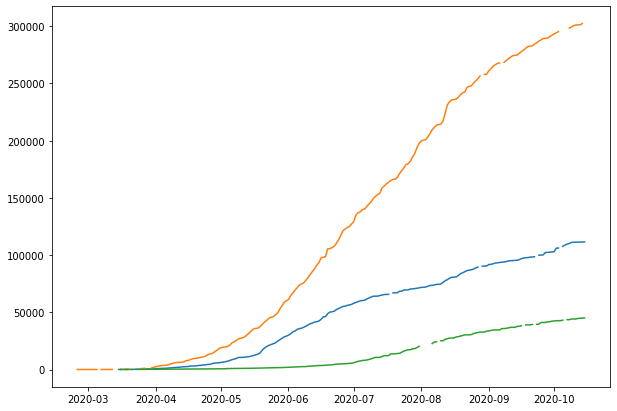

In [ ]:
plt.subplots(figsize=(10,7))
plt.plot(df_ca[[3304557, 3550308, 3106200]])
plt.show()

Observamos a presença de descontinuidade nas séries.

#### 1.1 Garantindo que as séries sejam monotônica e sem descontinuidades:

Interpolação para os dias faltantes

In [ ]:
df_ca_i = df_ca.interpolate(method='polynomial', order=2)

Substitui os primeiros dias com valores faltantes com 0:

In [ ]:
df_ca_i[:'2020-11-01'].fillna(value=0,inplace=True)

Verifica se restou algum dia com valores faltantes:

In [ ]:
df_temp = pd.DataFrame(df_ca_i.isna().sum())
df_temp[df_temp!=0].dropna()

,0
city_ibge_code,


Garantindo a monotonicidade crescente a fim de não haver casos negativos:

In [ ]:
cidades = df_ca_i.columns.tolist()
for c in cidades:
  s = df_ca_i[c]
  if not s.is_monotonic:
    for i,v in enumerate(s):
      if i>0:
        if v<s[i-1]:
          s[i] = s[i-1]
        df_ca_i[c] = s

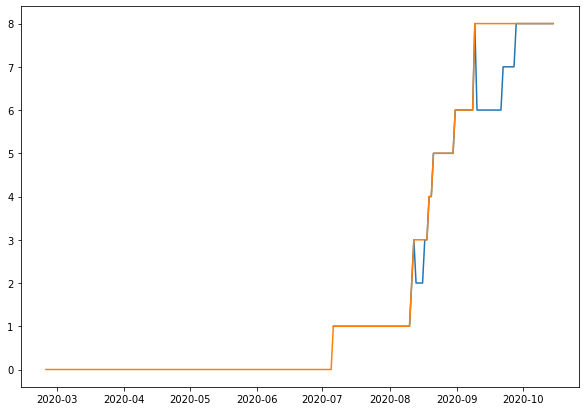

In [ ]:
plt.subplots(figsize=(10,7))
plt.plot(df_ca[[5221577]])
plt.plot(df_ca_i[[5221577]])
plt.show()

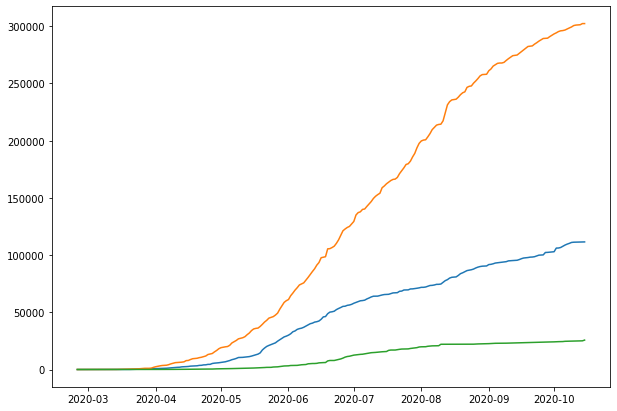

In [ ]:
plt.subplots(figsize=(10,7))
plt.plot(df_ca_i[[3304557, 3550308, 2408102]])
plt.show()

#### 1.2 Casos novos diários

In [ ]:
df_cn = df_ca_i.diff(periods=1)[1:]

In [ ]:
df_cn.to_csv('df_cn.csv')

Média móvel de 7 dias:

In [ ]:
df_casos_mm = df_cn.rolling(7).mean().dropna()

In [ ]:
df_casos_mm.to_csv('df_cn_mm7.csv')

[]

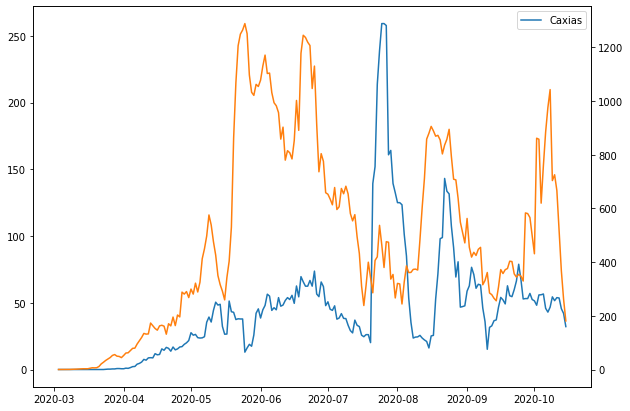

In [ ]:
# Niteroi x Rio
fig,ax1 = plt.subplots(figsize=(10,7))
ax1.plot(df_cn[3301702].rolling(7).mean(), label='Caxias')
ax2 = ax1.twinx()
ax2.plot(df_cn[3304557].rolling(7).mean(), c='C1', label='Rio')
ax1.legend()
plt.plot()

[]

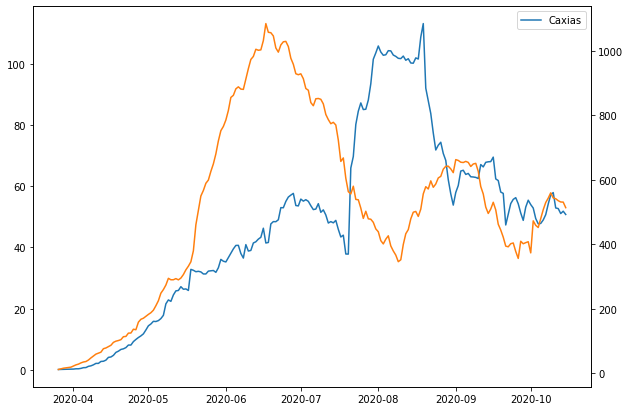

In [ ]:
# Niteroi x Rio
fig,ax1 = plt.subplots(figsize=(10,7))
ax1.plot(df_cn[3301702].rolling(30).mean(), label='Caxias')
ax2 = ax1.twinx()
ax2.plot(df_cn[3304557].rolling(30).mean(), c='C1', label='Rio')
ax1.legend()
plt.plot()

### 2 Construção da Rede

#### 2.1 Matriz de correlação

In [ ]:
M_Cor = df_casos_mm.corr()

In [ ]:
#M_Cor.to_csv('M_Cor.csv')

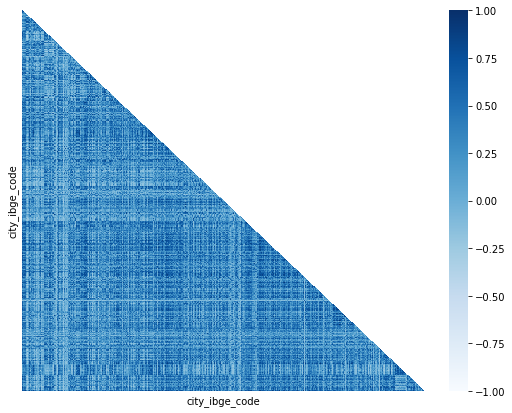

In [ ]:
fig, axs = plt.subplots(figsize=(9,7))
mask = np.triu(np.ones_like(M_Cor, dtype=bool)) # Generate a mask for the upper triangle
ax = sns.heatmap(M_Cor,mask=mask, cmap=plt.cm.Blues, xticklabels=False, yticklabels=False, vmin=-1, vmax=+1)
#plt.savefig('matrz_correlacao.pdf',format='pdf')

Limiar para a definição das arestas da rede:

In [ ]:
T = 0.85

In [ ]:
M_Cor.describe()

city_ibge_code,1100015,1100023,1100031,1100049,1100056,...,5222005,5222054,5222203,5222302,5300108
count,5565.000000,5565.000000,5565.000000,5565.000000,5565.000000,...,5565.000000,5565.000000,5565.000000,5565.000000,5565.000000
mean,0.456639,0.476554,0.383467,0.453747,0.456120,...,0.361698,0.337698,0.320212,0.424797,0.501660
std,0.235781,0.226991,0.216375,0.251942,0.237380,...,0.175251,0.228680,0.225650,0.279427,0.220362
min,-0.346932,-0.281620,-0.340778,-0.299517,-0.291929,...,-0.289266,-0.309010,-0.268808,-0.403917,-0.323141
25%,0.305017,0.312741,0.258071,0.280000,0.293188,...,0.246752,0.182414,0.144615,0.248484,0.353434
50%,0.485527,0.498477,0.420262,0.483758,0.490080,...,0.376213,0.367310,0.318481,0.471327,0.524829
75%,0.637780,0.655156,0.539457,0.655006,0.644484,...,0.490481,0.517442,0.493001,0.641329,0.668005
max,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
(M_Cor >= T).sum()[3550308]

21

In [ ]:
(M_Cor >= T).sum().describe()

count    5569.000000
mean       18.272760
std        34.903882
min         0.000000
25%         1.000000
50%         3.000000
75%        18.000000
max       294.000000
dtype: float64

In [ ]:
M_Cor[3304557].sort_values()[10:]

city_ibge_code
5106455   -0.116169
4118105   -0.116152
2607000   -0.114668
4214300   -0.112846
4320651   -0.112726
             ...   
3304557    1.000000
3108503         NaN
3110400         NaN
3149408         NaN
3165206         NaN
Name: 3304557, Length: 5559, dtype: float64

In [ ]:
M_Cor[3106200].sort_values()[-10:]

city_ibge_code
3543402    0.935115
3556701    0.935479
4106902    0.942890
3549805    0.944483
4100400    0.948452
3106200    1.000000
3108503         NaN
3110400         NaN
3149408         NaN
3165206         NaN
Name: 3106200, dtype: float64

Exemplo: BH x Almirante do Tamandaré (PR)

In [ ]:
M_Cor[3106200][4100400]

0.9484524332552371

[]

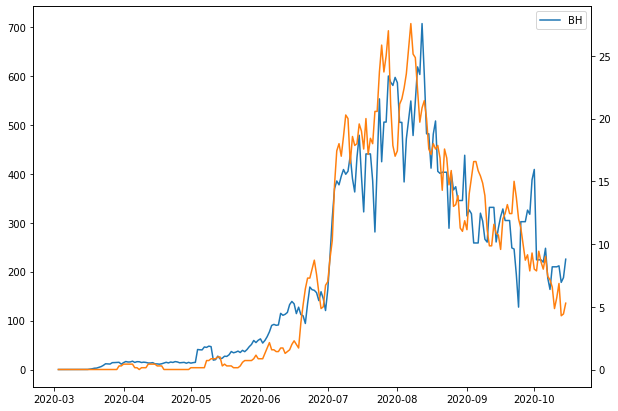

In [ ]:
# BH x Almirante do Itamandaré (PR)
fig,ax1 = plt.subplots(figsize=(10,7))
ax1.plot(df_cn[3106200].rolling(7).mean(), label='BH')
ax2 = ax1.twinx()
ax2.plot(df_cn[4100400].rolling(7).mean(), c='C1')
ax1.legend()
plt.plot()

#### 2.2 Distribuição de grau preliminar

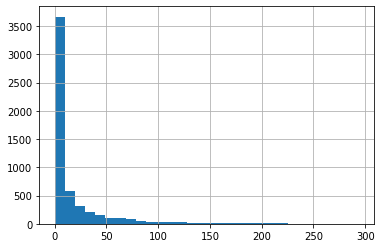

In [ ]:
(M_Cor >= T).sum().hist(bins=30)
plt.show()

Observamos uma distribuição de grau aparentemente com cauda pesada.

#### 2.3 Geração da rede

In [ ]:
df_A = (M_Cor>T).astype(int)      # Matriz de adjancências
np.fill_diagonal(df_A.values, 0)  # com diagonal 0

In [ ]:
df_A.to_csv('df_A085.csv')

In [ ]:
G = nx.from_pandas_adjacency(df_A)

Inclusão dos atributos:

In [ ]:
dic_municipios = df_mun.to_dict('index')

In [ ]:
nx.set_node_attributes(G, dic_municipios)

In [ ]:
G.nodes[3304557]

{'capital': True,
 'city': 'Rio de Janeiro',
 'idhf': 0.788615,
 'latitude': -22.9129,
 'longitude': -43.2003,
 'pib': 51776.18,
 'population': 6747815,
 'porte_idh': 3,
 'porte_pib': 3,
 'porte_pop': 7,
 'regiao': 'Sudeste',
 'uf': 'RJ'}

Visualização da rede:

In [ ]:
#random.seed(15)
#np.random.seed(15)
#plt.figure(figsize=(10,10))
#nx.draw_networkx(G, node_size=1, edge_color='grey', alpha=0.5, width=0.5, with_labels=False)
#plt.show()

Componentes conexas:

In [ ]:
tam_cc = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
print("Número de componentes conexas:", nx.number_connected_components(G)) 
print("Tamanho das componentes conexas:", tam_cc)

Número de componentes conexas: 2133
Tamanho das componentes conexas: [3370, 5, 5, 5, 5, 4, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

Maior componente conexa:

In [ ]:
maior_cc = max(nx.connected_components(G), key=len)
S = G.subgraph(maior_cc).copy()

Salva a rede no formato GraphML

In [ ]:
nx.write_graphml_lxml(S,"S.graphml")
nx.write_graphml_lxml(G,"G.graphml")

Visualização da componente conexa gigante:

In [ ]:
#random.seed(10)
#np.random.seed(10)
#plt.figure(figsize=(20,20))
#nx.draw_networkx(S, node_size=1, edge_color='grey', alpha=0.5, width=0.5, with_labels=False)
#plt.show()

Distância média da rede:

In [ ]:
4301602

4301602

In [ ]:
#d_mean = nx.average_shortest_path_length(S)
#print('Distância média:',d_mean)

In [ ]:
df_casos_mm

city_ibge_code,1100015,1100023,1100031,1100049,1100056,...,5222005,5222054,5222203,5222302,5300108
date,,,,,,,,,,,
2020-03-03,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000
2020-03-04,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000
2020-03-05,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000
2020-03-06,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000
2020-03-07,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.142857
...,...,...,...,...,...,...,...,...,...,...,...
2020-10-11,3.571429,7.142857,2.142857,7.714286,1.000000,...,3.000000,1.142857,0.0,1.285714,575.571429
2020-10-12,3.000000,7.857143,2.142857,5.000000,0.714286,...,3.000000,1.000000,0.0,1.285714,559.571429
2020-10-13,3.682136,9.102424,2.142857,5.500337,0.786589,...,2.000000,1.571429,0.0,1.571429,555.428571


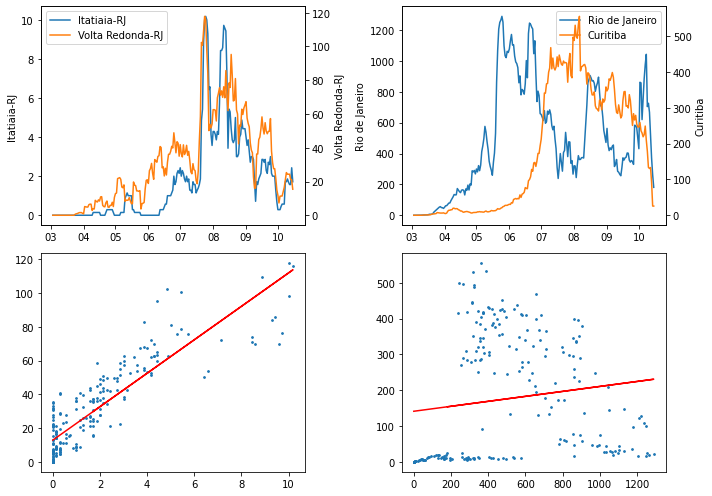

In [ ]:
from scipy.stats import linregress
import matplotlib.dates as mdates

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
months_fmt = mdates.DateFormatter('%m')
fig, ax = plt.subplots(2, 2,figsize=(10,7))

# Itatiaia x Volta Redonda
x1 = df_casos_mm[3302254]
y1 = df_casos_mm[3306305]
ax[0,0].plot(x1, label='Itatiaia-RJ')
ax2 = ax[0,0].twinx()
ax2.plot(y1, c='C1', label='Volta Redonda-RJ')
ax[0,0].set_ylabel('Itatiaia-RJ')
ax2.set_ylabel('Volta Redonda-RJ')

# Legendas
lines_1, labels_1 = ax[0,0].get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2
ax[0,0].legend(lines, labels, loc=0)
ax[0,0].xaxis.set_major_locator(months)
ax[0,0].xaxis.set_major_formatter(months_fmt)

# BH x Almirante
#x2 = df_casos_mm[3106200]
#y2 = df_casos_mm[4100400]
#ax[0,1].plot(x2, label='Belo Horizonte-MG')
#ax2 = ax[0,1].twinx()
#ax2.plot(y2, c='C1', label='Almirante Tamandaré-PR')
#ax[0,1].set_ylabel('Belo Horizonte-MG')
#ax2.set_ylabel('Belo Horizonte-MG')

# Legendas
#lines_1, labels_1 = ax[0,1].get_legend_handles_labels()
#lines_2, labels_2 = ax2.get_legend_handles_labels()
#lines = lines_1 + lines_2
#labels = labels_1 + labels_2
#ax[0,1].legend(lines, labels, loc=0)
#ax[0,1].xaxis.set_major_locator(months)
#ax[0,1].xaxis.set_major_formatter(months_fmt)

# Rio e Janeiro x Curitiba
x3 = df_casos_mm[3304557]
y3 = df_casos_mm[4106902]
ax[0,1].plot(x3, label='Rio de Janeiro')
ax2 = ax[0,1].twinx()
ax2.plot(y3, c='C1', label='Curitiba')
ax[0,1].set_ylabel('Rio de Janeiro')
ax2.set_ylabel('Curitiba')

# Legendas
lines_1, labels_1 = ax[0,1].get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2
ax[0,1].legend(lines, labels, loc=0)
ax[0,1].xaxis.set_major_locator(months)
ax[0,1].xaxis.set_major_formatter(months_fmt)

# Scatter
ax[1,0].scatter(x1, y1, s=3)
m1, b1, corr, _, _ = linregress(x1, y1)
ax[1,0].plot(x1, m1*x1+b1, c='r')

# Scatter
#ax[1,1].scatter(x2, y2, s=3)
#m2, b2, corr, _, _ = linregress(x2, y2)
#ax[1,1].plot(x2, m2*x2+b2, c='r')

# Scatter
ax[1,1].scatter(x3, y3, s=3)
m3, b3, corr, _, _ = linregress(x3, y3)
ax[1,1].plot(x3, m3*x3+b3, c='r')

plt.tight_layout()
plt.savefig('series.pdf', format='pdf')
plt.show()

## 3 Análise do Threshold

In [ ]:
!wget 'https://raw.githubusercontent.com/cleitonmoya/CPS765_Trabalho2/main/redes/S080.graphml'
!wget 'https://raw.githubusercontent.com/cleitonmoya/CPS765_Trabalho2/main/redes/S085.graphml'
!wget 'https://raw.githubusercontent.com/cleitonmoya/CPS765_Trabalho2/main/redes/S090.graphml'
S080 = nx.read_graphml('S080.graphml', node_type=int) # Componente conexa
S085 = nx.read_graphml('S085.graphml', node_type=int) # Componente conexa
S090 = nx.read_graphml('S090.graphml', node_type=int) # Componente conexa

--2021-01-19 22:25:00--  https://raw.githubusercontent.com/cleitonmoya/CPS765_Trabalho2/main/redes/S080.graphml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14068456 (13M) [text/plain]
Saving to: ‘S080.graphml.2’

S080.graphml.2      100%[===================>]  13.42M  49.8MB/s    in 0.3s    

2021-01-19 22:25:01 (49.8 MB/s) - ‘S080.graphml.2’ saved [14068456/14068456]

--2021-01-19 22:25:01--  https://raw.githubusercontent.com/cleitonmoya/CPS765_Trabalho2/main/redes/S085.graphml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4994200 (4

Distribuição de grau:

In [ ]:
degrees80 = np.array([val for (node, val) in S080.degree()])
degrees85 = np.array([val for (node, val) in S085.degree()])
degrees90 = np.array([val for (node, val) in S090.degree()])

T=0.80

In [ ]:
from statistics import median
print('Máximo:', degrees80.max())
print('Mínimo:', degrees80.min())
print('Média:',degrees80.mean())
print('Mediana:', median(degrees80))
print('Desvio padrão:', degrees80.std())

Máximo: 608
Mínimo: 1
Média: 70.42622950819673
Mediana: 29
Desvio padrão: 95.72134061805558


T=0.85

In [ ]:
print('Máximo:', degrees85.max())
print('Mínimo:', degrees85.min())
print('Média:',degrees85.mean())
print('Mediana:', median(degrees85))
print('Desvio padrão:', degrees85.std())

Máximo: 293
Mínimo: 1
Média: 28.501483679525222
Mediana: 11.0
Desvio padrão: 41.15215485768324


T=0.90

In [ ]:
print('Máximo:', degrees90.max())
print('Mínimo:', degrees90.min())
print('Média:',degrees90.mean())
print('Mediana:', median(degrees90))
print('Desvio padrão:', degrees90.std())

Máximo: 89
Mínimo: 1
Média: 9.559389515593896
Mediana: 5
Desvio padrão: 12.571690494259188


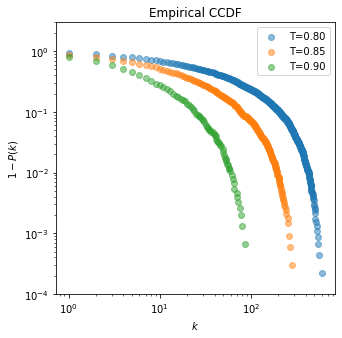

In [ ]:
x80, f80 = np.unique(degrees80, return_counts=True)
x85, f85 = np.unique(degrees85, return_counts=True)
x90, f90 = np.unique(degrees90, return_counts=True)


ccdf80 = 1-f80.cumsum()/f80.sum()
ccdf85 = 1-f85.cumsum()/f85.sum()
ccdf90 = 1-f90.cumsum()/f90.sum()

plt.figure(figsize=(5,5))
plt.scatter(x80, ccdf80,alpha=0.5, label='T=0.80')
plt.scatter(x85, ccdf85,alpha=0.5, c='C1', label='T=0.85')
plt.scatter(x90, ccdf90,alpha=0.5, c='C2', label='T=0.90')

plt.title('Empirical CCDF')
plt.xlabel('$k$')
plt.ylabel('$1-P(k)$')
plt.xscale('log')
plt.yscale('log')
plt.ylim(10**-4, 3*10**0)
plt.legend()
plt.savefig('limiar.pdf', format='pdf')
plt.show()